In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from scipy.stats import norm, kurtosis, shapiro
import statistics
from astropy.io import ascii
import math
import seaborn as sns
from scipy.stats import skew
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import scipy.integrate as integrate
import scipy.special as special

# Homework 01 - Astrostatistics

## 01. Take a normal distribution with mean equals to 100 and variance equals to 10. Produce N samples with 8 data points each assuming such a distribution, and prove the central limit theorem using those samples.

a) producing the normal distribution with parameters $\mu$, $\sigma$ and N (number of samples):

In [2]:
mu, sigma = 100, np.sqrt(10)
gaussian_pdf = []

for N in [100, 1000, 1000000]:
    gaussian_dist = [] 
    for i in range(N):
        s = np.random.normal(mu, sigma, 8)
        gaussian_dist.append(s)
    gaussian_pdf.append(gaussian_dist)

b) calculating the mean value for each one of the distributions, considering the number of samples:

In [3]:
mean_0 = np.mean(gaussian_pdf[0])
mean_1 = np.mean(gaussian_pdf[1])
mean_2 = np.mean(gaussian_pdf[2])
print(mean_0, mean_1, mean_2)

100.02269346582942 99.99199067504028 100.00224070333222


c) added all the values from each vector generated and stored in gaussian_dist into the values list so we can plot the distribution containing all points:

In [4]:
pdf_values = []

for i in range(len(gaussian_pdf)):
    values = []
    for j in range(len(gaussian_pdf[i])):
        for k in range(len(gaussian_pdf[i][j])):
            values.append(gaussian_pdf[i][j][k])
    pdf_values.append(values)
    

d) generated a gaussian PDF to compare with the histogram:

In [5]:
def gaussian(mu, sigma, x):
    return (1 / (sigma * np.sqrt(2*np.pi))) * np.exp(-(x - mu)**2 / (2*sigma**2))

e) plotting the histogram for different values of N and comparing with the gaussian PDF:

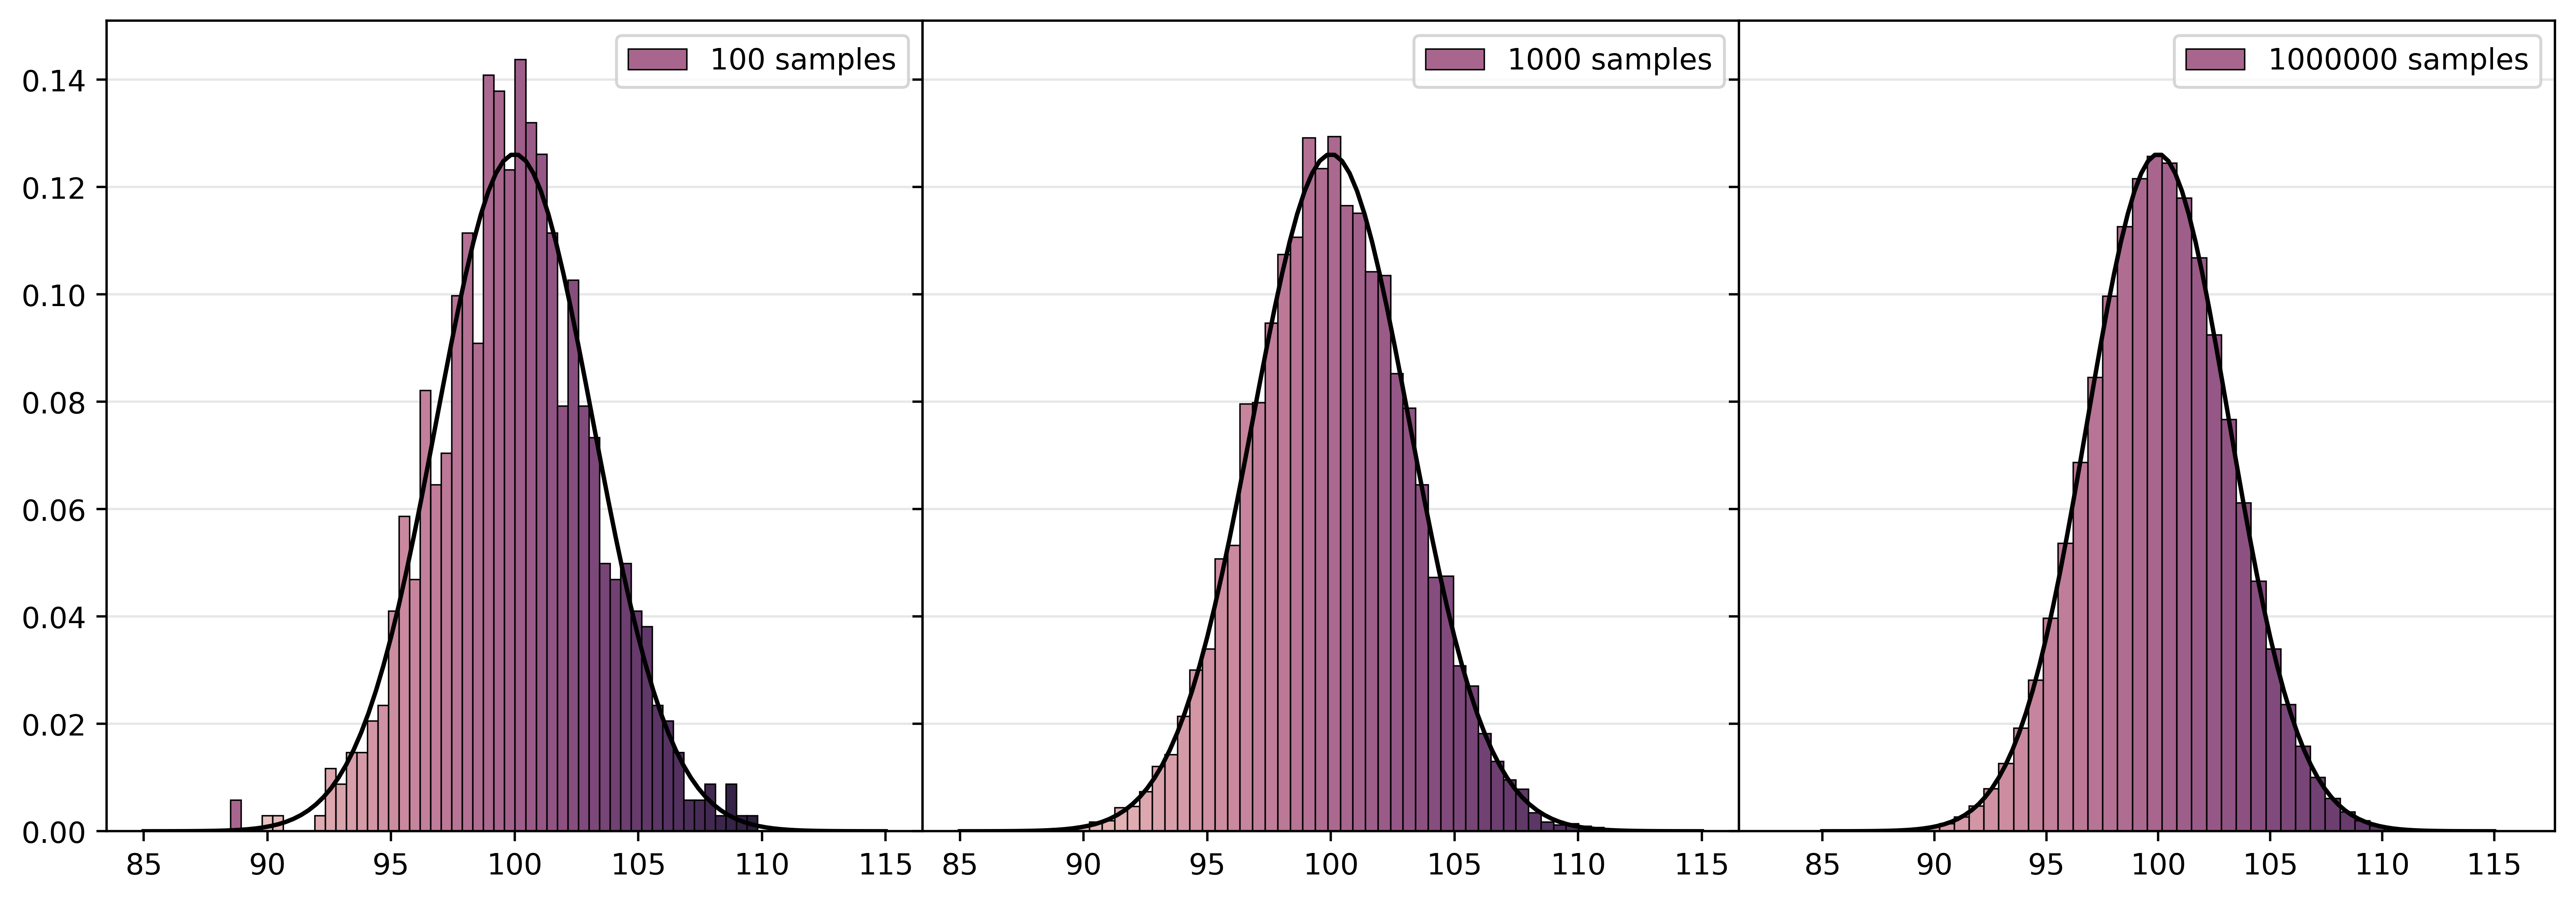

In [6]:
x = np.linspace(85, 115, 100)
y = gaussian(100, np.sqrt(10), x)
N = [100, 1000, 1000000]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=500, sharey = True)

for j in range(len(pdf_values)):
    values, bins = np.histogram(pdf_values[j], bins=50, density=True)
    axs[j].bar(bins[0] + (bins[1] - bins[0])/2, values[0], width = bins[1]-bins[0], edgecolor = 'black', lw = 0.5, facecolor = sns.cubehelix_palette(50)[25], label = f'{N[j]} samples')
    for i in range(1, len(values)):
        axs[j].bar(bins[i] + (bins[1] - bins[0])/2, values[i], width = bins[1]-bins[0], edgecolor = 'black', lw = 0.5, facecolor = sns.cubehelix_palette(50)[i])
    axs[j].plot(x, y, color='black')
    axs[j].legend()
    axs[j].set_axisbelow(True)
    axs[j].grid(True, axis='y', alpha=0.3)

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

As we saw in Modulus 2, the law of large numbers says that the mean of these random variables tends to the mean population distribution ($\mu$) from which the sample was originally obtained, as the number of samples tend to infinity. Since we defined the mean to be 100 at the beginning of the problem, this is going to be approximately the mean value for each one of the cases. For 100 samples, for example, the mean was calculated to be $99.815$, while for 1000 samples, the mean was $99.969$ and for $1000000$, we found $100.001$. So, as we can see, the larger the N, the closer the distribution will be to a Gaussian distribution and the mean of the random variables generated tends to the mean population distribution. 

## 02. Consider now the DR12 quasar (QSO) catalogue from the SDSS, which comprises 297,301 uniquely indentified QSOs

### a. Download the catalogue from the SDSS website - or any other database. State where the dataset was obtained from. 

    https://www.sdss4.org/dr17/algorithms/boss-dr12-quasar-catalog/

### b. Plot a histogram of the redshift distribution of the objects in this catalogue. State what is the bin width in these plots.


Opening catalog data as a table with astropy:

In [7]:
hdu = fits.open('DR12Q.fits')
qso_cat = Table(hdu[1].data)
qso_cat

SDSS_NAME,RA,DEC,THING_ID,PLATE,MJD,FIBERID,Z_VI,Z_PIPE,ERR_ZPIPE,ZWARNING,Z_PCA,ERR_ZPCA,PCA_QUAL,Z_CIV,Z_CIII,Z_MGII,SDSS_MORPHO,BOSS_TARGET1,ANCILLARY_TARGET1,ANCILLARY_TARGET2,EBOSS_TARGET0,NSPEC_BOSS,PLATE_DUPLICATE,MJD_DUPLICATE,FIBERID_DUPLICATE,SDSS_DR7,PLATE_DR7,MJD_DR7,FIBERID_DR7,UNIFORM,ALPHA_NU,SNR_SPEC,SNR_DUPLICATE,SNR_1700,SNR_3000,SNR_5150,FWHM_CIV,BHWHM_CIV,RHWHM_CIV,AMP_CIV,REWE_CIV,ERR_REWE_CIV,FWHM_CIII,BHWHM_CIII,RHWHM_CIII,AMP_CIII,REWE_CIII,ERR_REWE_CIII,FWHM_MGII,BHWHM_MGII,RHWHM_MGII,AMP_MGII,REWE_MGII,ERR_REWE_MGII,BAL_FLAG_VI,BI_CIV,ERR_BI_CIV,AI_CIV,ERR_AI_CIV,CHI2TROUGH,NCIV_2000,VMIN_CIV_2000,VMAX_CIV_2000,NCIV_450,VMIN_CIV_450,VMAX_CIV_450,REW_SIIV,REW_CIV,REW_ALIII,RUN_NUMBER,PHOTO_MJD,RERUN_NUMBER,COL_NUMBER,FIELD_NUMBER,OBJ_ID,PSFFLUX,IVAR_PSFFLUX,PSFMAG,ERR_PSFMAG,TARGET_FLUX,MI,DGMI,EXTINCTION,EXTINCTION_RECAL,HI_GAL,VAR_MATCHED,VAR_CHI2,VAR_A,VAR_GAMMA,RASS_COUNTS,RASS_COUNTS_SNR,SDSS2ROSAT_SEP,N_DETECTION_XMM,FLUX02_12KEV_SGL,ERR_FLUX02_12KEV_SGL,FLUX02_2KEV,ERR_FLUX02_2KEV,FLUX2_12KEV,ERR_FLUX2_12KEV,FLUX02_12KEV,ERR_FLUX02_12KEV,LUM02_2KEV_SGL,LUM05_2KEV,LUM2_12KEV,LUM02_2KEV,LUMX2_10_UPPER,SDSS2XMM_SEP,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,JMAG,ERR_JMAG,JSNR,JRDFLAG,HMAG,ERR_HMAG,HSNR,HRDFLAG,KMAG,ERR_KMAG,KSNR,KRDFLAG,SDSS2MASS_SEP,W1MAG,ERR_W1MAG,W1SNR,W1CHI2,W2MAG,ERR_W2MAG,W2SNR,W2CHI2,W3MAG,ERR_W3MAG,W3SNR,W3CHI2,W4MAG,ERR_W4MAG,W4SNR,W4CHI2,CC_FLAGS,PH_FLAG,SDSS2WISE_SEP,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP
str18,float64,float64,int32,int32,int32,int32,float64,float32,float32,int32,float64,float64,float64,float64,float64,float64,int16,int64,int64,int64,int64,int32,int32[32],int32[32],int32[32],int32,int32,int32,int32,int16,float64,float64,float64[32],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,int32,float64,float64,int32,float64,float64,float64,float64,float64,int16,int32,str3,int16,int16,str19,float32[5],float32[5],float32[5],float32[5],float64[5],float64,float64,float32[5],float32[5],float64,int16,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,int16,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,str4,float64,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,float64,float64,float64
000000.45+174625.4,0.001898285183756343,17.773739129913793,268514930,6173,56238,528,2.3090972900390625,2.3090973,0.000943339,0,2.307638681965085,-1.0,0.34618227908419724,2.312307913620226,2.306384949267177,2.3046866469028076,0,2199023796224,0,0,0,0,-1 .. -1,-1 .. -1,-1 .. -1,0,-1,-1,-1,0,0.5373362131787354,0.7794849254538647,-1.0 .. -1.0,0.5856829364201617,0.9155019040054463,-1.0,4278.790034099103,1595.2886495993666,2683.501384499736,2.1532874185263067,44.002864381226416,1.4009716614738188,3575.0010890068424,1554.1216580326109,2020.8794309742316,0.706666936497054,38.42856717206801,15.851724034869367,7996.403883272336,4579.190127488224,3417.2137557841124,0.22327953562476657,69.38600007026068,17.880810804162163,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,7713,54741,301,4,231,1237678601842131080,1.038477 .. 2.6584318,12.359663 .. 0.8528282,22.439793 .. 21.362684,0.28713453 .. 0.38640517,1.0384769439697266 .. 2.6584317684173584,-23.882931269031133,-0.08209104090929031,0.14619489 .. 0.041944176,0.113614365 .. 0.03385113,21.92971261383344,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,0.30231887102127075,8.785573140381723,0.7275648713111877,4.5373589

Finding the ideal number of bins that should be used in the histogram using Sturges's rule and calculating the width of each bin:

In [8]:
def sturge_optimal_bins(data: np.array) -> int:
    """ Sturge's rule for optimal bin selection
    Parameters: 
        data (np.array) - a one-dimensional array with data
    Returns:
        nbins (int) - number of bins
    """
    assert data.ndim == 1
    n = data.size
    nbins = math.ceil(1.0 + np.log2(n))
    
    width = math.ceil((data.max() - data.min()) / nbins)
    width = max(1, width)
    return nbins

print(f'Size of the data: {qso_cat['Z_PIPE'].size}')
print(f'Number of bins: {sturge_optimal_bins(qso_cat['Z_PIPE'])}')
print(f'Width of the bins: {(qso_cat['Z_PIPE'].max() - qso_cat['Z_PIPE'].min()) / 20}')


Size of the data: 297301
Number of bins: 20
Width of the bins: 0.3508093059062958


The number of bins is going to be 20, with a width of 0.351.

Plotting the data in the column Z_PIPE as a histogram with the number of bins determined by the Sturges's rule: 

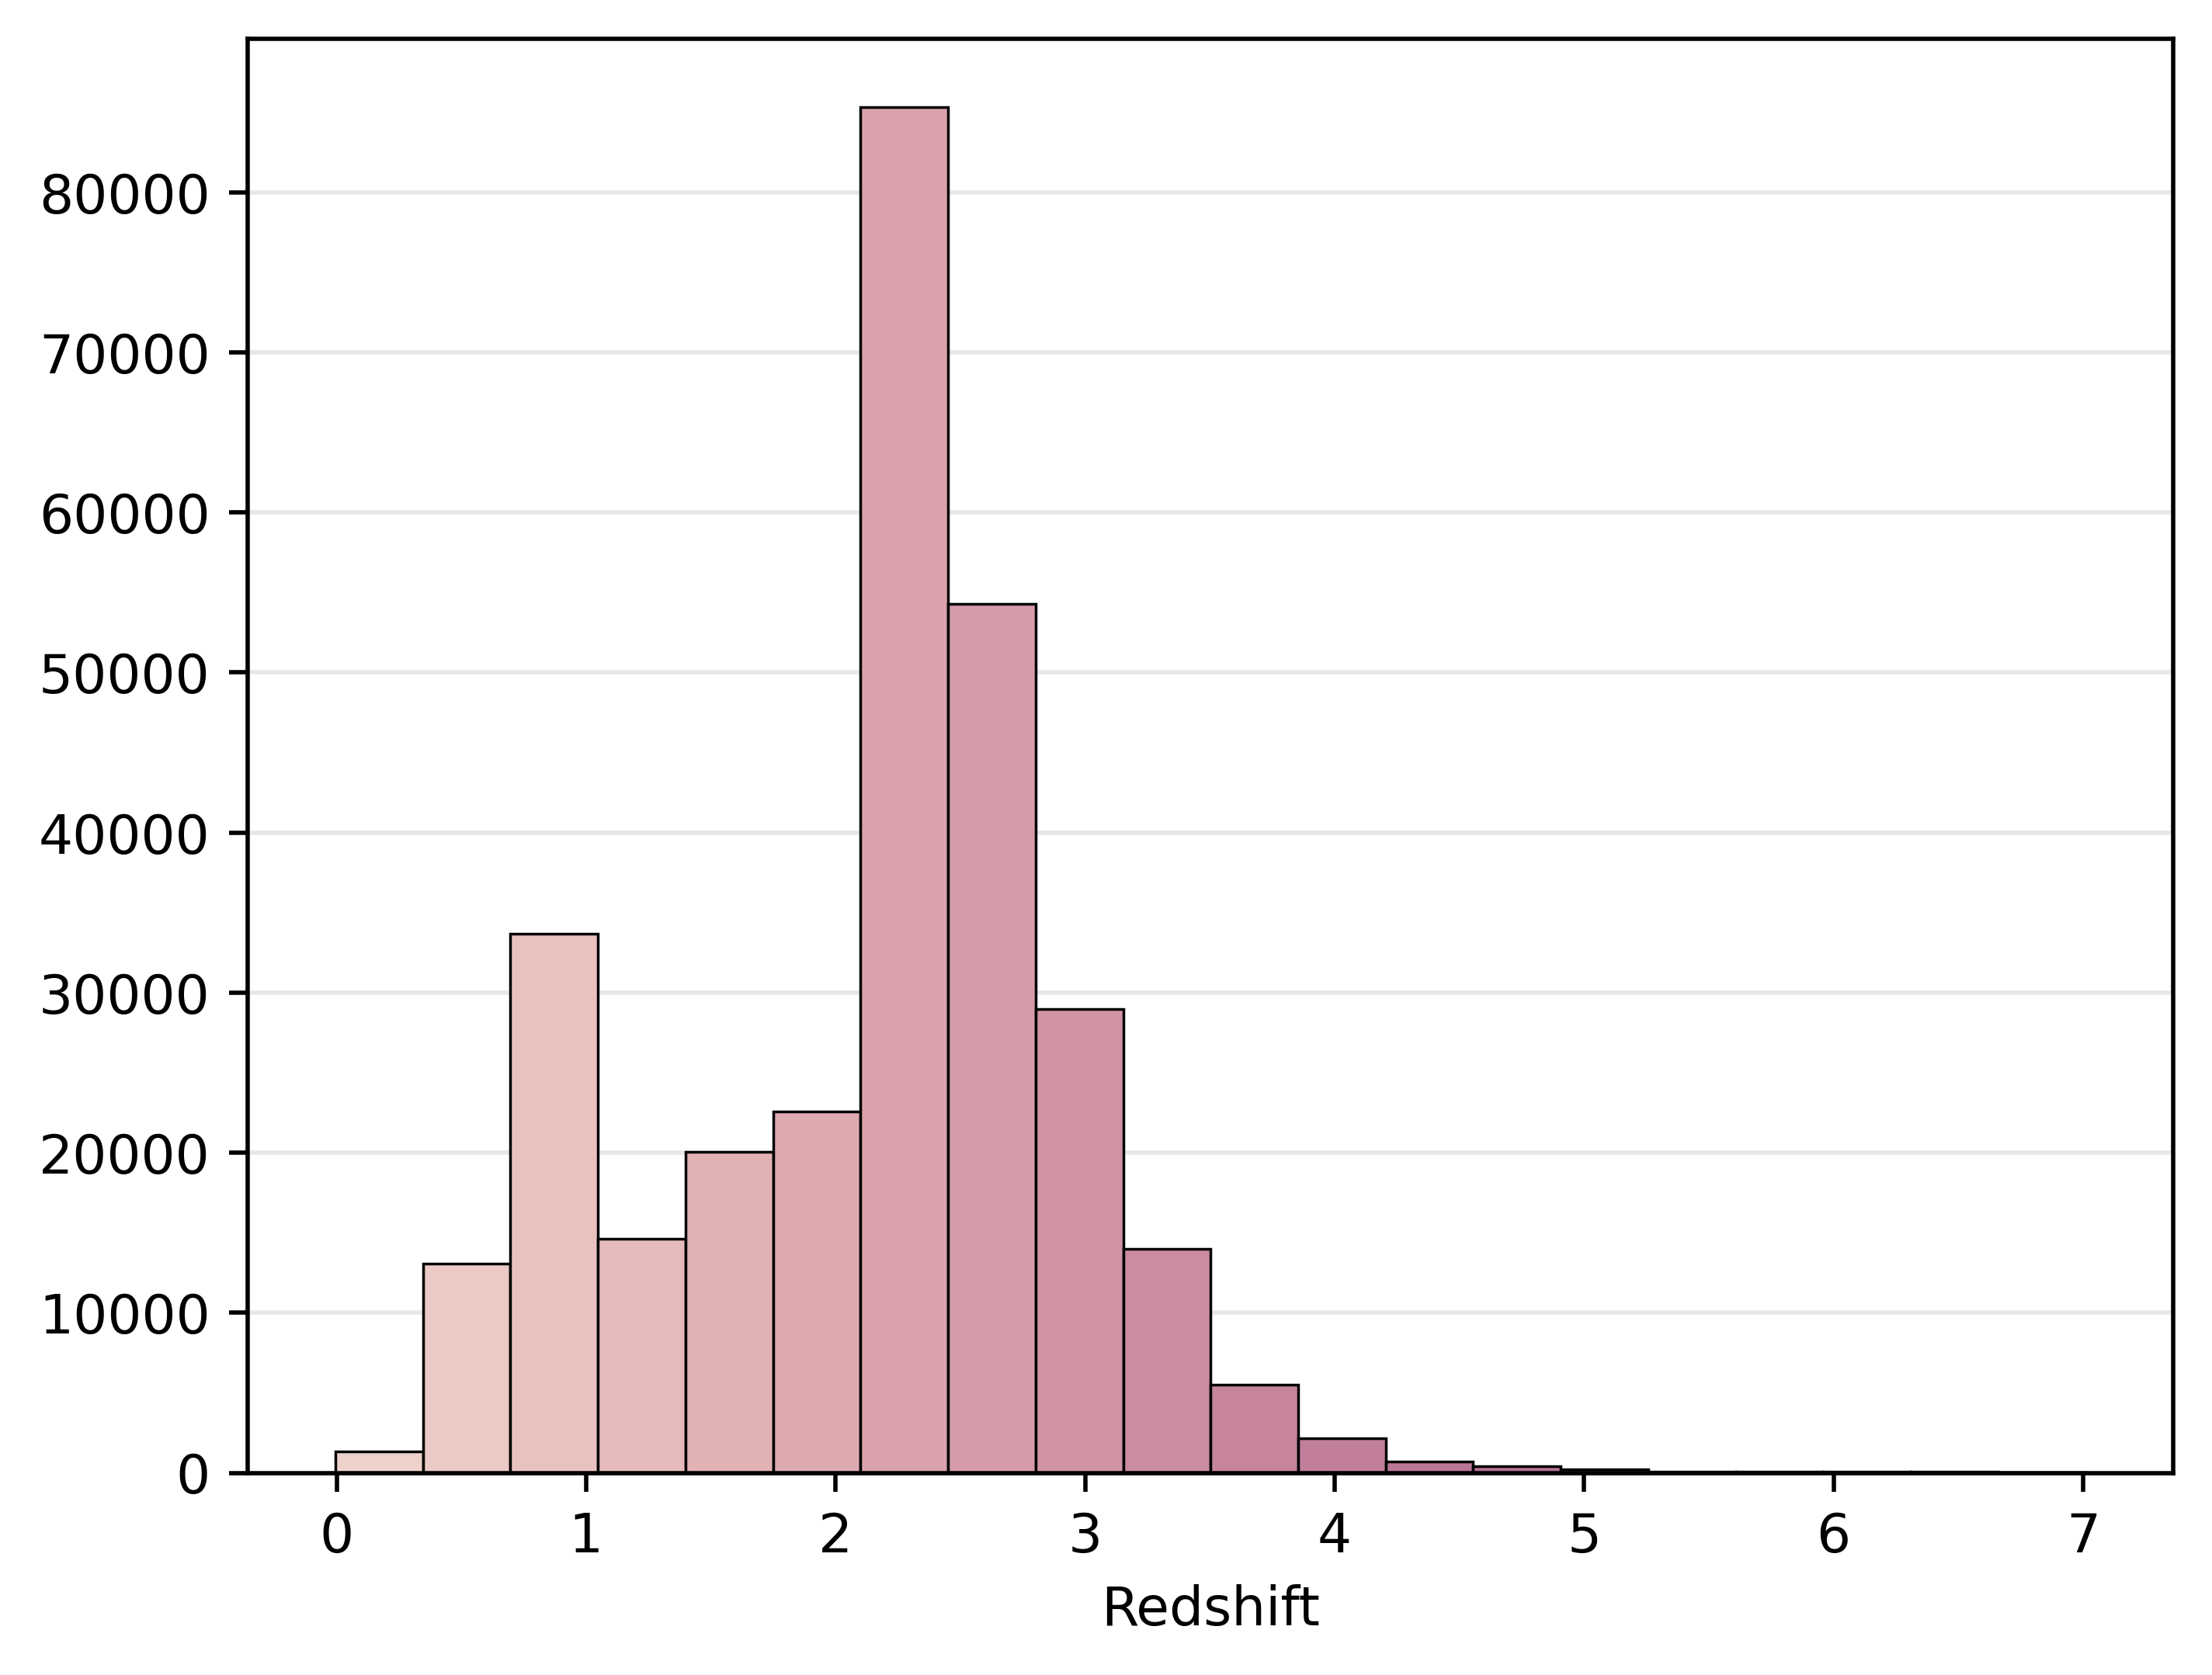

In [9]:
fig, ax = plt.subplots(dpi = 500)

ax.set_axisbelow(True)
ax.grid(True, axis='y', alpha=0.3)

values, bins = np.histogram(qso_cat['Z_PIPE'], bins=sturge_optimal_bins(qso_cat['Z_PIPE']))

for i in range(len(values)):
    ax.bar(bins[i] + (bins[1] - bins[0])/2, values[i], width = bins[1]-bins[0], edgecolor = 'black', lw = 0.5, facecolor = sns.cubehelix_palette(30)[i])

# fig.suptitle('zCMB distribution for SNIa in the Pantheon+ Catalog')
ax.set_xlabel('Redshift')
plt.show()


### c. Fit a gaussian curve to this histogram and compute the mean, variance and higher order momenta (skewness and kurtosis). Would you consider that this gaussian pdf is a good fit to the data? Explain. 

Fitting a gaussian curve and calculating the mean and variance of the distribution:

Variance = 0.6753467917442322
Mean = 2.1371426582336426


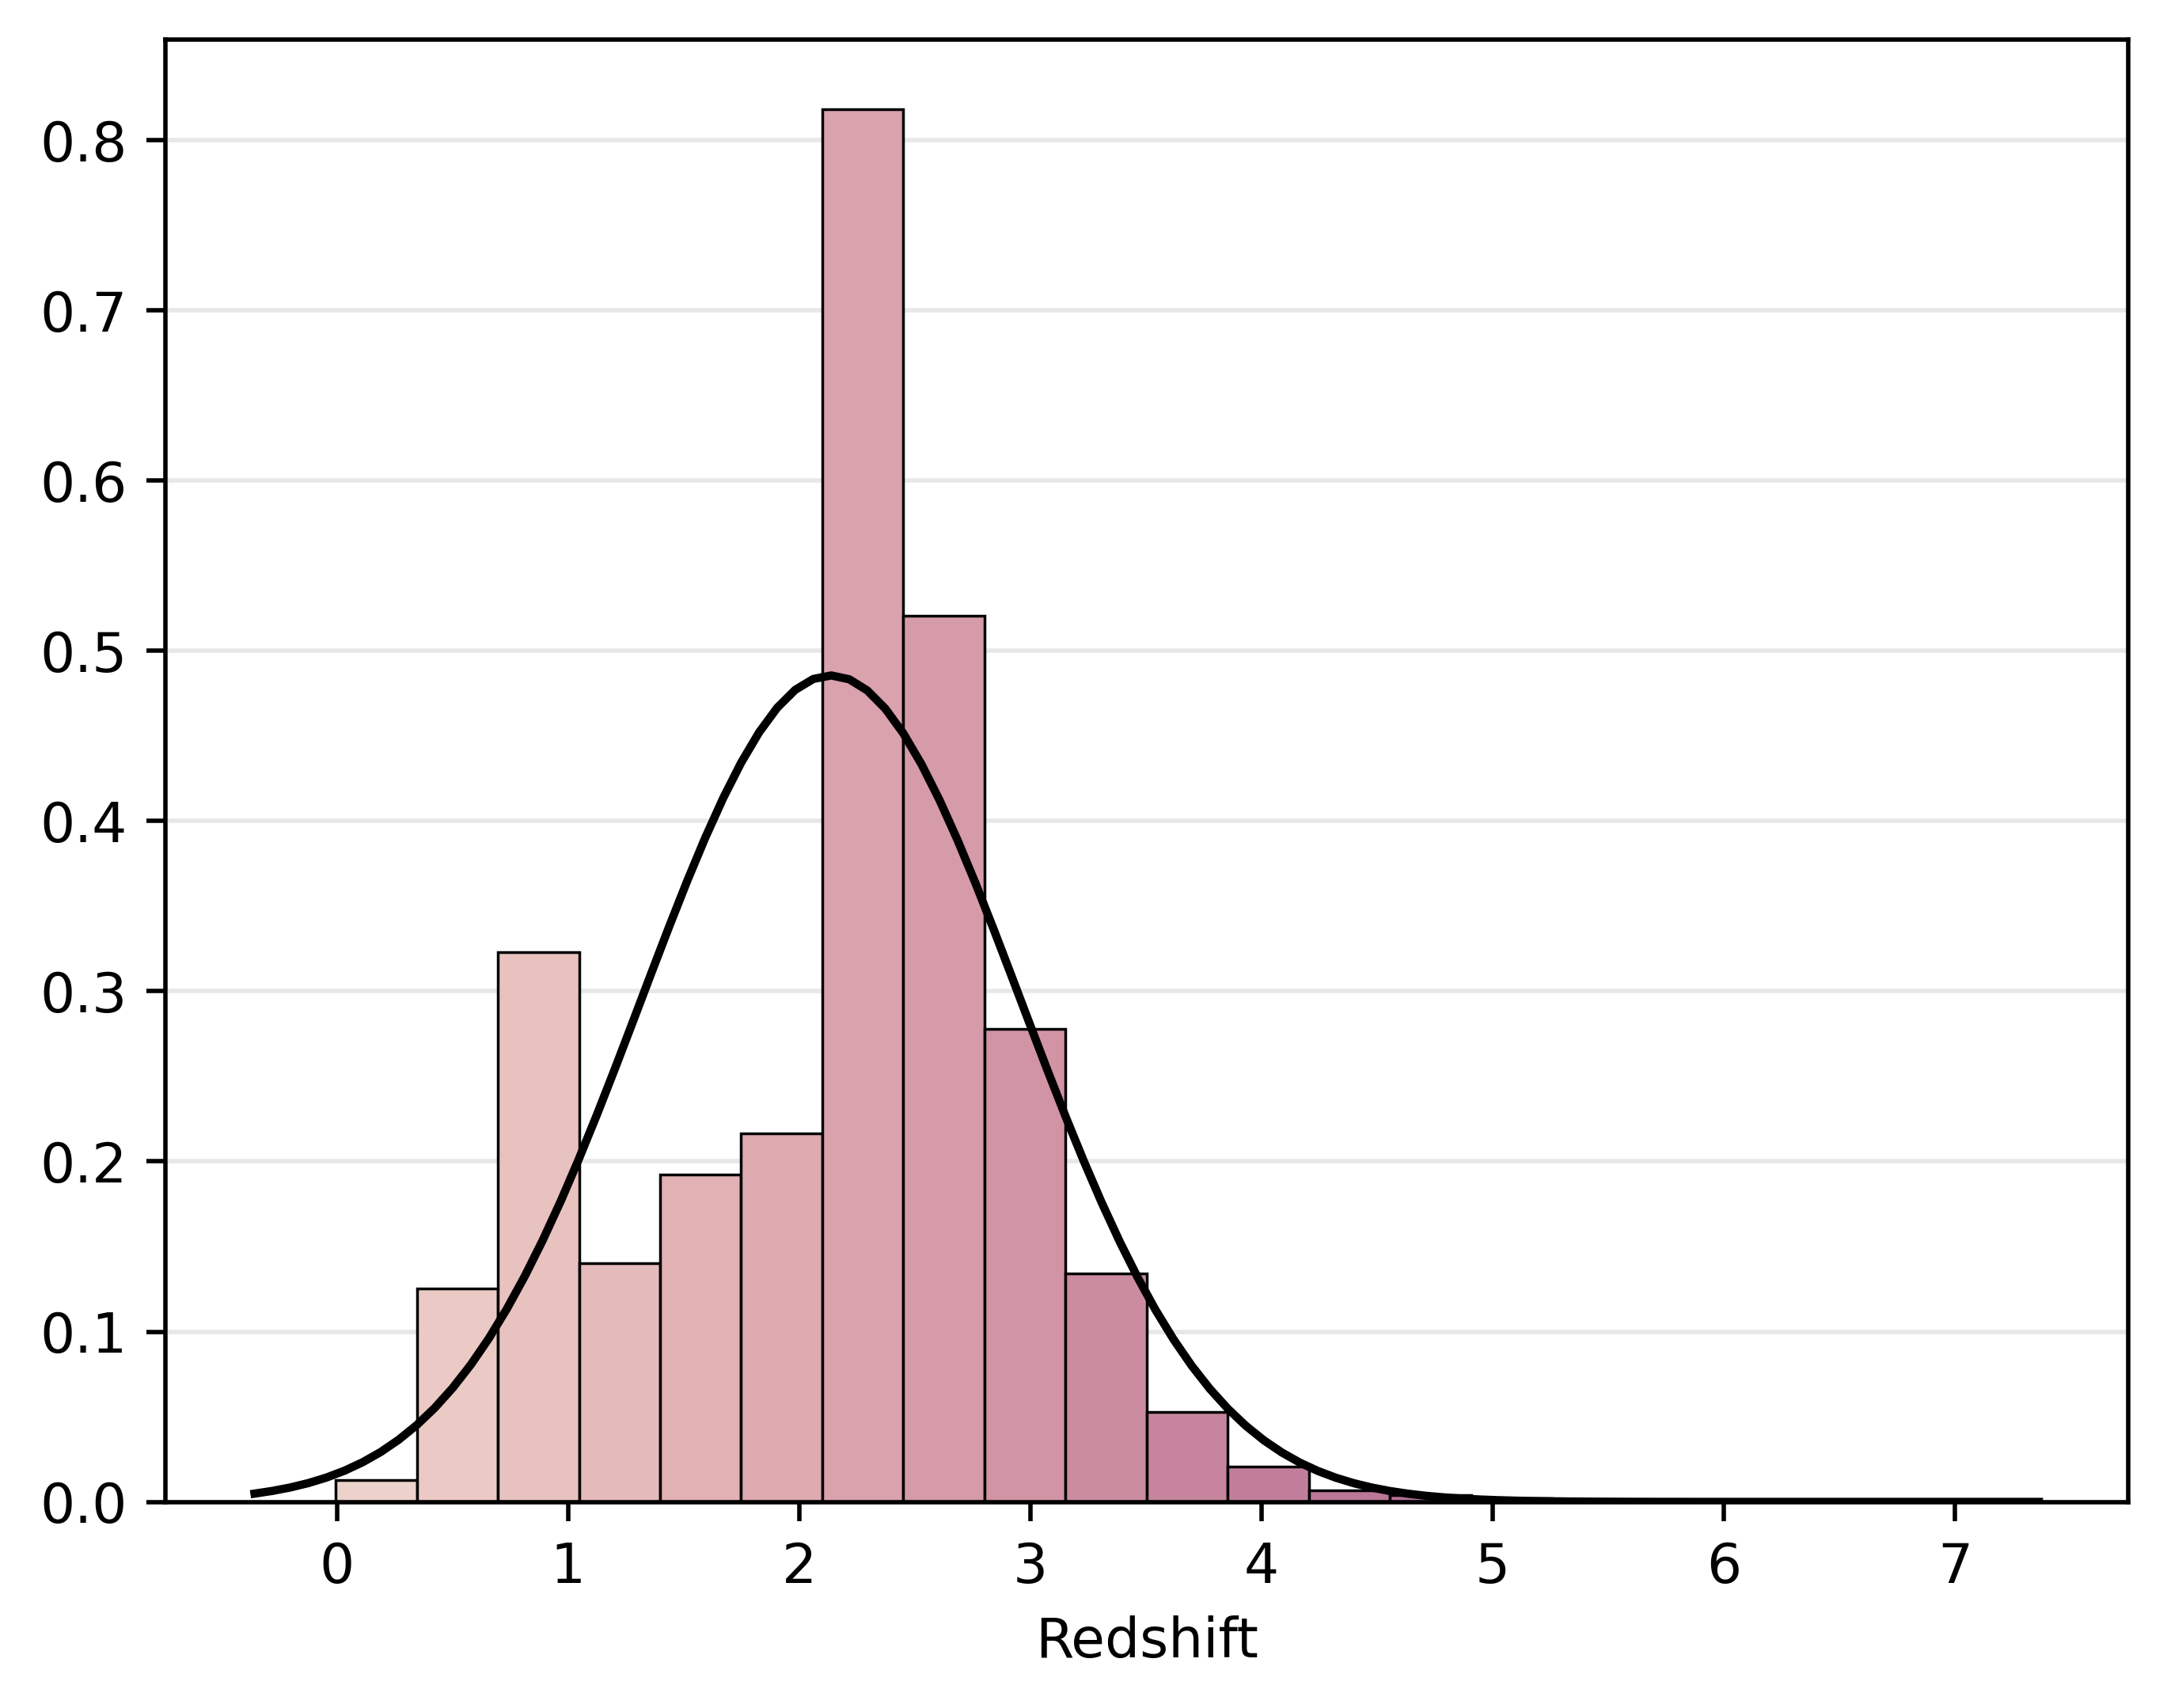

In [10]:
mu, std = norm.fit(qso_cat['Z_PIPE'])

fig, ax = plt.subplots(dpi = 500)

ax.set_axisbelow(True)
ax.grid(True, axis='y', alpha=0.3)

values, bins = np.histogram(qso_cat['Z_PIPE'], bins=sturge_optimal_bins(qso_cat['Z_PIPE']), density=True)

for i in range(len(values)):
    ax.bar(bins[i] + (bins[1] - bins[0])/2, values[i], width = bins[1]-bins[0], edgecolor = 'black', lw = 0.5, facecolor = sns.cubehelix_palette(30)[i])

# fig.suptitle('zCMB distribution for SNIa in the Pantheon+ Catalog')
ax.set_xlabel('Redshift')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, color='black')

print(f'Variance = {std**2}')
print(f'Mean = {mu}')
plt.show()

Calculating the high order momenta (skewness and kurtosis):

In [11]:
skewness = skew(qso_cat['Z_PIPE'])
kts = kurtosis(qso_cat['Z_PIPE'])

print(f'Skewness = {skewness}')
print(f'Kurtosis = {kts}')

Skewness = -0.16064541041851044
Kurtosis = 0.3096034526824951


The value found for skewness indicates that the distribution is asymmetric to the left, as we can see in the figure, while the value found for kurtosis means a more peaked distribution than a normal distribution.

Performing a Shapiro-Wild test to test gaussianity:

In [12]:
test = shapiro(qso_cat['Z_PIPE'])
test.pvalue

/home/mavi/.miniforge3/envs/astrostatistics/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 297301.
  res = hypotest_fun_out(*samples, **kwds)


np.float64(2.046819938723429e-110)

Placing a threshold of $0.003$, which corresponds to a confidence interval of $3\sigma$, we can reject the null hypothesis of normality for the data.

### d. Instead of a gaussian curve, try to fit a gamma function to this histogram. What are the best fits for those parameters? Moreover, which one provides a better fit to the data, the gaussian or the Gamma curve? Explain.

## 3. Consider now the Type Ia Supernova (S) compilation named Union2.1 sent in the mail. Also consider that the file columns represent SN name, redshift, distance modulus and their associated uncertainty, respectively. You can neglect the last column in the mean time.

### a. Given that the distance modulus follows $\mu \equiv m-M = 5logd - 5$, where $d$ denotes the distance to the source in Pc (parsec) unit, show that $\mu = 5logd_L + 25$, for a luminosity distance $d_L$ given in Mpc.

Importing data and giving names to the columns of the table

In [13]:
sn1a_data = ascii.read('/home/mavi/Documentos/astrostatistics/SCPUnion2.1_mu_vs_z(1).txt')

sn1a_data.rename_column('col1', 'sn1a_names')
sn1a_data.rename_column('col2', 'sn1a_z')
sn1a_data.rename_column('col3', 'sn1a_distance')
sn1a_data.rename_column('col4', 'sn1a_inc_distance')

z = sn1a_data['sn1a_z']
mu_data = sn1a_data['sn1a_distance']
sigma = sn1a_data['sn1a_inc_distance']
# sn1a_data
sn1a_data

sn1a_names,sn1a_z,sn1a_distance,sn1a_inc_distance,col5
str6,float64,float64,float64,float64
1993ah,0.028488,35.3465833928,0.223905932998,0.128418942246
1993ag,0.050043,36.6823679154,0.166828851413,0.128418942246
1993o,0.052926,36.8176912545,0.1557559148,0.128418942246
1993b,0.070086,37.4467365424,0.158466934433,0.128418942246
1992bs,0.062668,37.4834093505,0.156099434739,0.128418942246
1992br,0.087589,38.2290570494,0.187745679272,0.128418942246
1992bp,0.078577,37.4881622607,0.155635656185,0.128418942246
1992bo,0.017227,34.6543699503,0.199337179559,0.128418942246
1992bl,0.042233,36.3364595483,0.167174042338,0.128418942246


Note: the distance modulus $\mu = m - M$ is the difference between the apparent magnitude $m$ and the absolute magnitude $M$ of an astronomical object. It's related to $d$ by $\mu = 5logd -5$ (in parsecs). If we want $\mu$ considering the luminosity distance in Mpc (which we'll call $d_L$), we need to take $d = d_L \times 10^6$. So, 

$\mu = 5log(d_L \times 10^6) - 5 \rightarrow \mu = 5(logd_L + log10^6) - 5 \rightarrow \mu = 5(logd_L + 6) - 5 \rightarrow \mu = 5logd_L +30 - 5 \rightarrow \mu = 5logd_L + 25$.


### b. In the stardart cosmological model, namely the flat $\Lambda CDM$ paradigm, the luminosity distance reads

### $d_L = cH_0^{-1}(1+z) \int_{0}^{z} \frac{dz'}{\sqrt{\Omega_m(1-z')^3 + (1 - \Omega_m)}}$

### where $\Omega_m$ denotes the total matter density parameter of the Universe. By fixing the Hubble Constant $H_0 = 70 \; km \; s^{-1} \; Mpc^{-1}$, compute the $\chi^2$ for $\Omega_m = 0.20, \Omega_m = 0.30$ and $\Omega_m = 0.40$, which reads

### $\chi^2 = \sum_i {\frac{(\mu^{model}(z_i; \Omega_m,H_0) - \mu_i^{data})^2}{\sigma_i^2}}$

### In this case, $\mu^{model}$ and $\mu^{data}$ consist on the distance modulus assuming the standart cosmological model and the observational data meaurement, respectively, $\sigma$ denotes the uncertainty of the $\mu^{data}$ measure, $z$ is the observational redshift and the $i$ subscript corresponds to the i-th data point of the observational sample. What $\Omega_m$ value provided the best fit among them all - in other words, the smallest $\chi^2$?

Computing $d_L$ to find the $\mu_{model}$:

In [14]:
H_0 = 70 # km s^-1 Mpc^-1
c = 3E5 # km/s
omega_m = 0.4
d_L = []

def integrand(z):
    return 1 / np.sqrt(omega_m*(1-z)**3 + (1 - omega_m))

for i in range(len(z)):
    d_L.append((c / H_0) * (1 + z[i]) * integrate.quad(integrand, 0, z[i])[0])

d_L


[np.float64(126.64044955418436),
 np.float64(228.56994827764888),
 np.float64(242.6063534841539),
 np.float64(328.13711473659987),
 np.float64(290.74561034091874),
 np.float64(418.9018168051052),
 np.float64(371.722045648647),
 np.float64(75.48952478664148),
 np.float64(191.02481310123238),
 np.float64(205.66150363755966),
 np.float64(163.81468847571705),
 np.float64(86.14478212061208),
 np.float64(490.4127628860372),
 np.float64(121.36938571257075),
 np.float64(351.22896799707195),
 np.float64(117.45564969209826),
 np.float64(227.98292699036529),
 np.float64(136.41221538596795),
 np.float64(71.54652928725385),
 np.float64(67.48751564775489),
 np.float64(136.0649937075832),
 np.float64(108.47575556858756),
 np.float64(105.8686397950328),
 np.float64(115.3897025053625),
 np.float64(223.2637731357813),
 np.float64(107.51360887661669),
 np.float64(66.28277527543759),
 np.float64(160.24833204476866),
 np.float64(222.6347306275949),
 np.float64(96.90433281408562),
 np.float64(621.5503637937

Computing $\mu_{model}$:

In [15]:
mu_model = []

for i in range(len(d_L)):
    mu_model.append(5 * np.log10(d_L[i]) + 25)

mu_model

[np.float64(35.512862217679384),
 np.float64(36.79509565008799),
 np.float64(36.92451085089222),
 np.float64(37.58027677542452),
 np.float64(37.31756583249499),
 np.float64(38.11056121964712),
 np.float64(37.85109159239874),
 np.float64(34.389433457286025),
 np.float64(36.40544891720798),
 np.float64(36.56576503352422),
 np.float64(36.07176420134515),
 np.float64(34.67614488455263),
 np.float64(38.45280882038675),
 np.float64(35.42054576924792),
 np.float64(37.72795163814163),
 np.float64(35.34936955729614),
 np.float64(36.78951162553954),
 np.float64(35.674266310443386),
 np.float64(34.27294285519225),
 np.float64(34.146117205877346),
 np.float64(35.66873202957467),
 np.float64(35.176663419063885),
 np.float64(35.12383666640381),
 np.float64(35.31083526833418),
 np.float64(36.744091300005884),
 np.float64(35.15731719967434),
 np.float64(34.10700342070203),
 np.float64(36.02396758915949),
 np.float64(36.73796457230635),
 np.float64(34.93171597891636),
 np.float64(38.96738162491663),
 n

Using the values ​​found for $\mu_{model}$ and the values ​​present in the original table for $\mu_{data}$ and its uncertainty $\sigma$ to calculate $\chi^2$:

In [16]:
chi_list = []

for i in range(len(mu_model)):
    chi_list.append((mu_model[i] - mu_data[i])**2 / sigma[i]**2)

chi_square = np.sum(chi_list)

print(f'Chi-square = {chi_square} for Omega_m = {omega_m}')

Chi-square = 3336.121877746423 for Omega_m = 0.4


Plotting a comparison between data and the curves for each value of $\mu_{model}$ considered to see the differences visually.

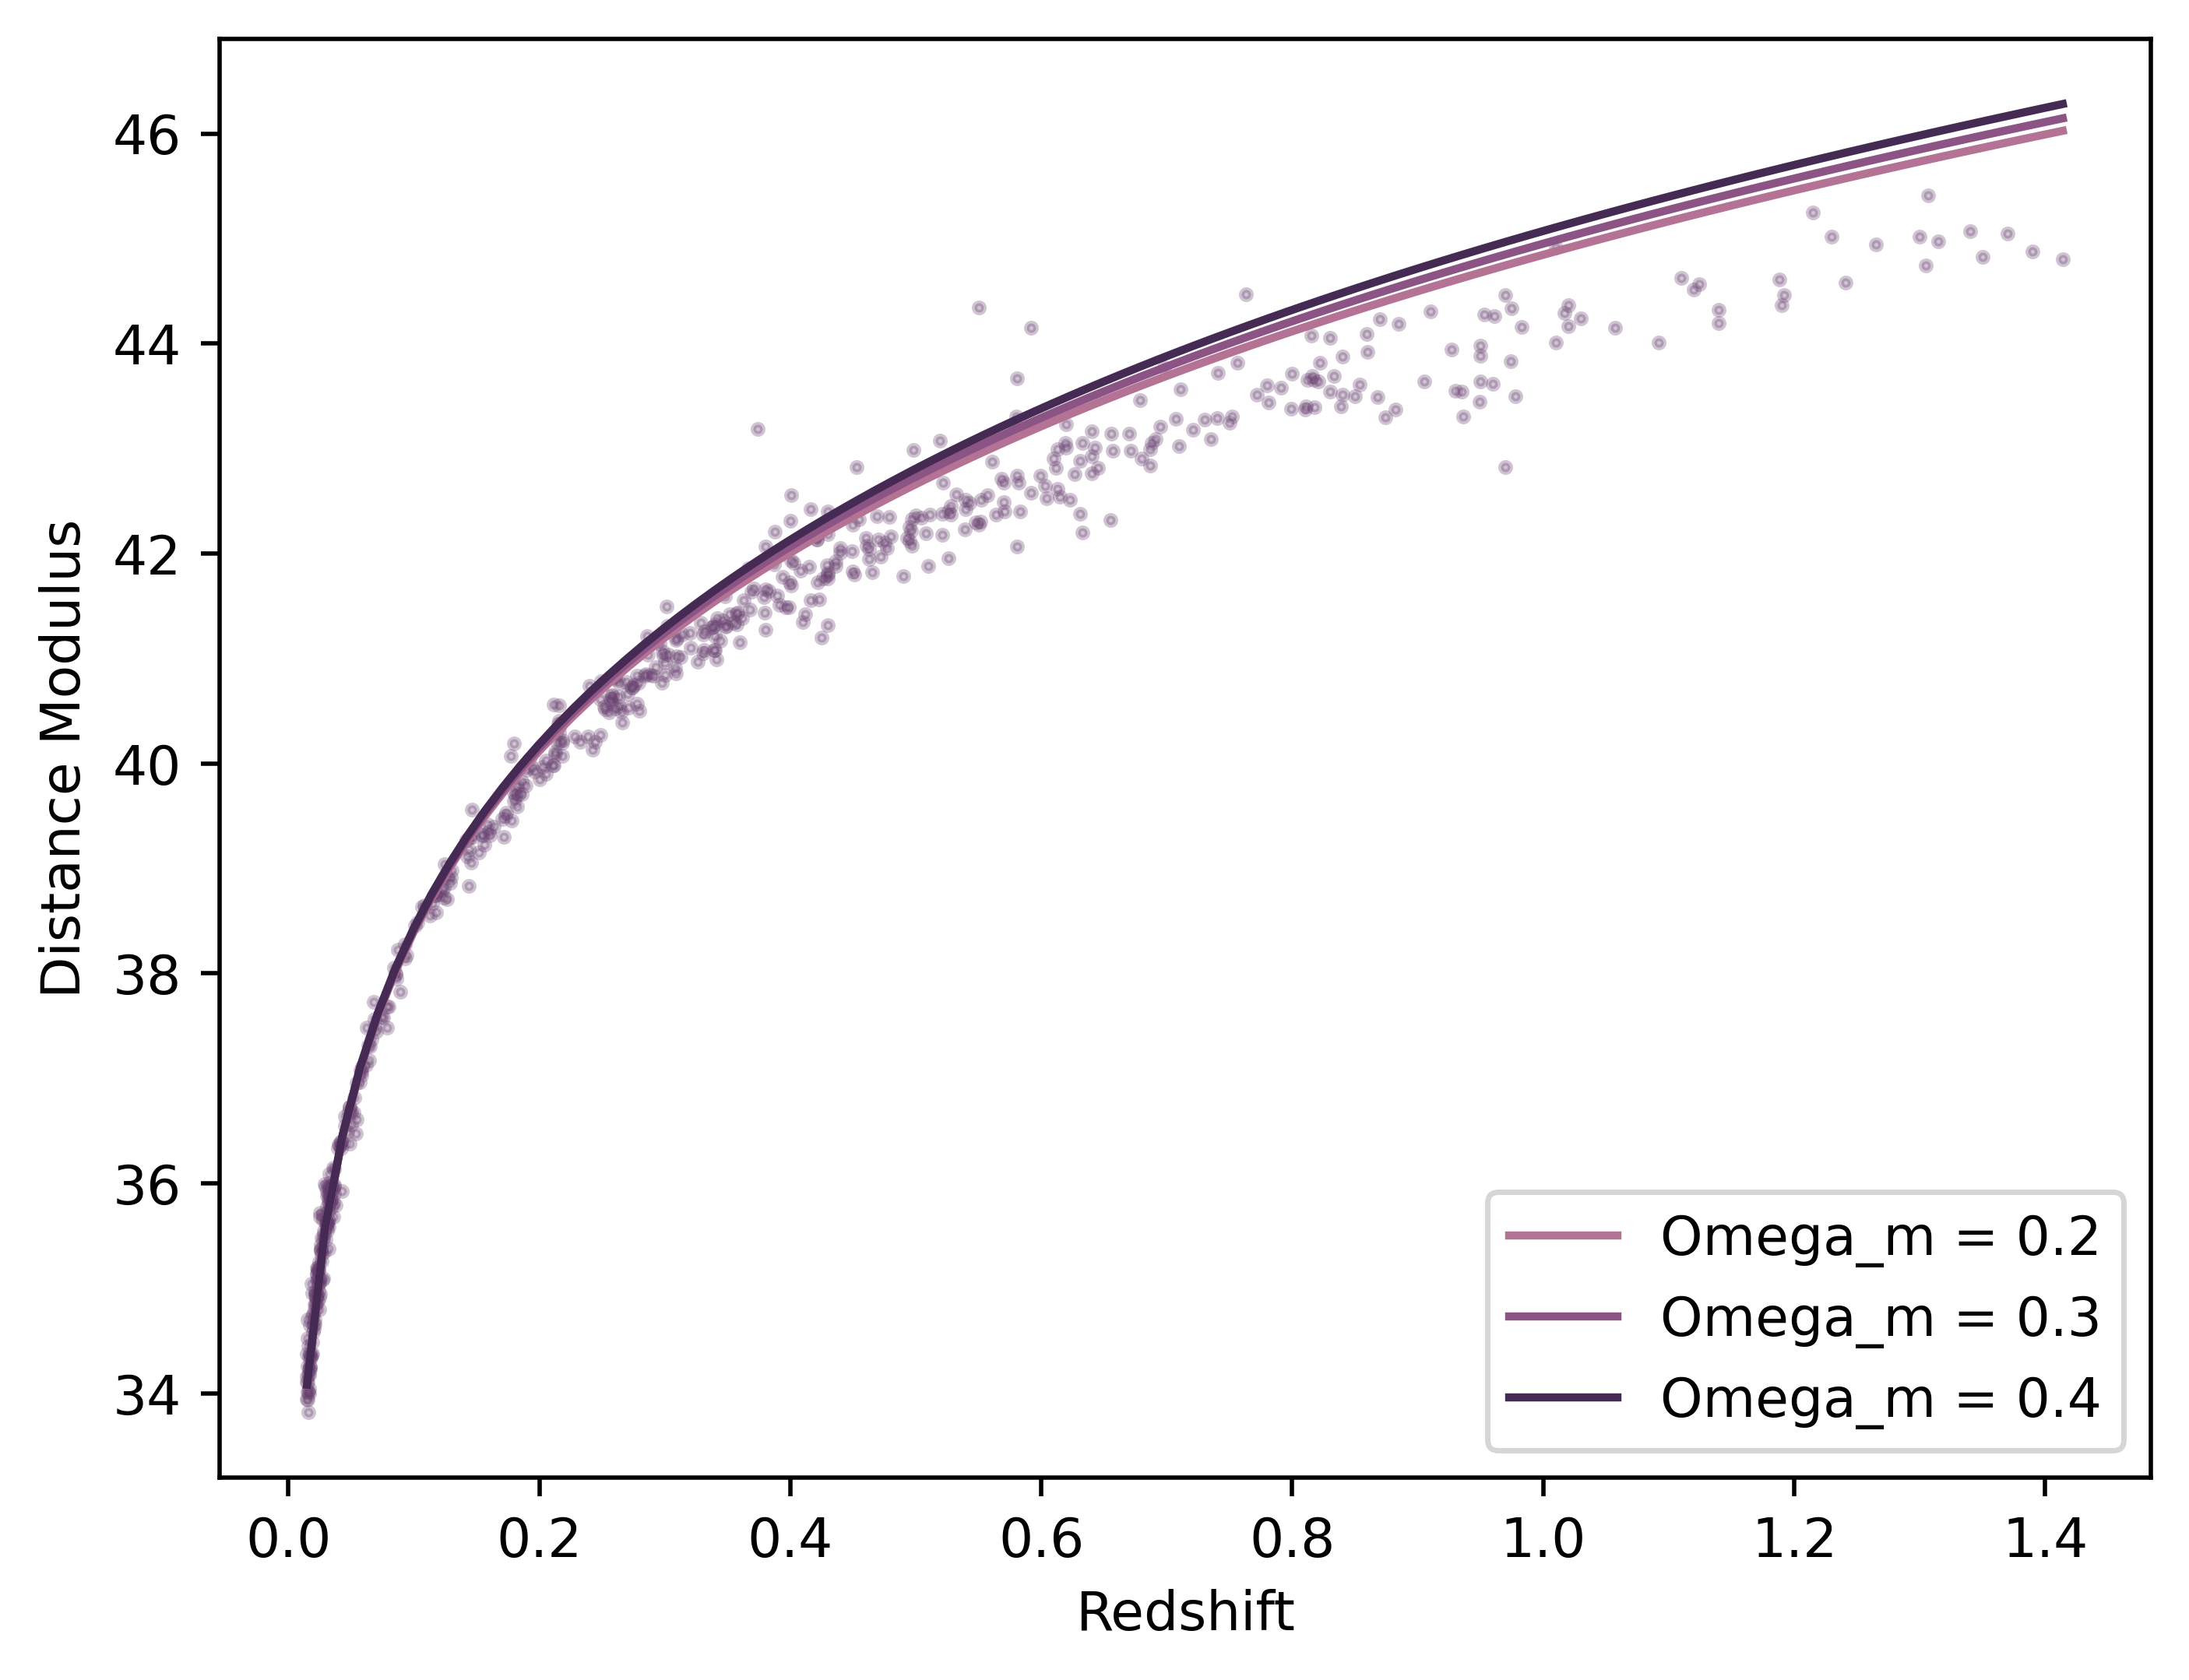

In [17]:
fig, ax = plt.subplots(dpi = 500)

z_new = np.linspace(min(z), max(z), 100)
H_0 = 70 # km s^-1 Mpc^-1
c = 3E5 # km/s
d_L2 = []
d_L3 = []
d_L4 = []

def integrand(z, omega_m):
    return 1 / np.sqrt(omega_m*(1-z)**3 + (1 - omega_m))

for omega_m1, d_L in zip([0.2, 0.3, 0.4], [d_L2, d_L3, d_L4]):
    for z_ in z_new:
        d_L.append((c / H_0) * (1 + z_) * integrate.quad(integrand, 0, z_, args=(omega_m1))[0])

mu_model2 = []
mu_model3 = []
mu_model4 = []

for d_L, mu_model in zip([d_L2, d_L3, d_L4], [mu_model2, mu_model3, mu_model4]):
    for d_Li in d_L:
        mu_model.append(5 * np.log10(d_Li) + 25)

plt.scatter(z, mu_data, alpha=0.3, s=3, color='#643c6c')
plt.plot(z_new, mu_model2, color='#b47394', label = 'Omega_m = 0.2')
plt.plot(z_new, mu_model3, color='#8c5484', label = 'Omega_m = 0.3')
plt.plot(z_new, mu_model4, color='#452a53', label = 'Omega_m = 0.4')
plt.ylabel('Distance Modulus')
plt.xlabel('Redshift')
plt.legend(loc='lower right')
plt.show()

### c. In statistical inference, a quick way to verify whether the fit of a parameter is good or not is the so-called reduced $\chi^2$, hereafter $\chi_{\nu}^2$, which is expressed as the $\chi^2$ divided by the number of degrees of freedom – so the number of data points minus the number of constraints, i.e., the numbers of parameters in a model. Given the values obtained for the latter quantity, what is the $\Omega_m$ value that gives the best fit to the data? Explain. Tip: Note that $\chi_{\nu}^2 \sim 1$ is a good indicator for a reasonable fit. Values above (below) this threshold may indicate underfitting (overfitting).

The number of data points can be obtained by using $len(data)$, and for our case, the number of constraints is 1, since $\Omega_m$ is the only parameter in the model. Given that, we calculate $\chi_{\nu}^2$ for each $\Omega_m$. 

In [18]:
red_chisq = chi_square / (len(sn1a_data) - 1)

print(f'Reduced chi-square = {red_chisq} for Omega_m = {omega_m}')


Reduced chi-square = 5.761868528059452 for Omega_m = 0.4


The values found were $3.577$ for $\Omega_m = 0.2$,  $4.531$ for $\Omega_m = 0.3$, and $5.762$ for $\Omega_m = 0.4$. As we can see, $\Omega_m = 0.2$ gives the best fit to the data compared to the other $\Omega$'s, but it's still not a good fit, since the $\chi_{\nu}^2$ value indicates underfitting (we can also see this visually in the figure of the last cell).

### d. Compute the best fit value overall for $\Omega_m$, rather than fixing it at specific values, using the $\chi^2$ as in Eq. (3). Make a plot of the $\chi^2$ in function of $\Omega_m$, as well as the likelihood, according to $\mathcal{L} \propto exp(-\chi^2/2)$. What happens if you plot $\mathcal{L} / \mathcal{L}_{max}$? Explain. 

Calculating $d_L$ for $\Omega_m \in [0, 0.9]$ using 1000 points. The interval was defined only til 0.9 since for higher values, $\Omega_m$ was returning 'not a number' $\rightarrow$ the argument inside the square root in the denominator was assuming negative values. The values calculated were stored in a matrix for each $\Omega_m$.  

In [19]:
g_omega_m = np.linspace(0, 0.9, 1000)

H_0 = 70 # km s^-1 Mpc^-1
c = 3E5 # km/s
d_L = np.zeros((len(g_omega_m), len(z)))

def integrand(z, omega_m):
    return 1 / np.sqrt(omega_m*(1-z)**3 + (1 - omega_m))

for i in range(len(g_omega_m)):
    for j in range(len(z)):
        d_L[i][j] = (c / H_0) * (1 + z[j]) * integrate.quad(integrand, 0, z[j], args=(g_omega_m[i]))[0]

d_L

array([[  125.56956919,   225.20272221,   238.83069204, ...,
         6407.31857143, 11533.82142857,  4333.41      ],
       [  125.57194074,   225.21008657,   238.83893602, ...,
         6409.32789595, 11537.95259577,  4334.59509275],
       [  125.57431248,   225.21745188,   238.84718112, ...,
         6411.3394308 , 11542.08873663,  4335.78135533],
       ...,
       [  128.02690918,   233.06126388,   247.66271073, ...,
        12502.8904391 , 26970.35837716,  7210.77201577],
       [  128.02947191,   233.06971141,   247.67224372, ...,
        12528.86838943, 27054.78560271,  7219.62288233],
       [  128.03203485,   233.07816017,   247.68177818, ...,
        12555.07937953, 27140.21528117,  7228.52234524]])

Calculating the $\mu_{model}$ values for each $d_L$. NumPy was used to make the code faster, since there is a lot of points. 

In [20]:
mu_model = np.add(np.multiply(5, np.log10(d_L)), 25)

mu_model

array([[35.49442202, 36.76286818, 36.89045069, ..., 44.03338159,
        45.30986612, 43.18414891],
       [35.49446303, 36.76293919, 36.89052564, ..., 44.03406245,
        45.31064375, 43.18474267],
       [35.49450405, 36.7630102 , 36.8906006 , ..., 44.03474385,
        45.31142204, 43.18533687],
       ...,
       [35.5365063 , 36.83735049, 36.96930311, ..., 45.48505213,
        47.15443359, 44.28990882],
       [35.53654977, 36.83742919, 36.96938669, ..., 45.48955924,
        47.16122048, 44.29257256],
       [35.53659324, 36.83750791, 36.96947028, ..., 45.49409731,
        47.16806644, 44.29524764]])

In order to easily compute all the operations, the data from both columns, $\mu_{data}$ and $\sigma$, were transformed into matrices of the same shape as $\mu_{model}$.

In [22]:
mu_datamatrix = np.zeros(mu_model.shape)
mu_data = np.array(mu_data)

for i in range(mu_model.shape[0]):
    mu_datamatrix[i,:] = mu_data

mu_data = mu_datamatrix

In [23]:
sigmamatrix = np.zeros(mu_model.shape)
sigma = np.array(sigma)

for i in range(mu_model.shape[0]):
    sigmamatrix[i,:] = sigma

sigma = sigmamatrix

sigma

array([[0.22390593, 0.16682885, 0.15575591, ..., 0.19401359, 0.56031745,
        0.24142813],
       [0.22390593, 0.16682885, 0.15575591, ..., 0.19401359, 0.56031745,
        0.24142813],
       [0.22390593, 0.16682885, 0.15575591, ..., 0.19401359, 0.56031745,
        0.24142813],
       ...,
       [0.22390593, 0.16682885, 0.15575591, ..., 0.19401359, 0.56031745,
        0.24142813],
       [0.22390593, 0.16682885, 0.15575591, ..., 0.19401359, 0.56031745,
        0.24142813],
       [0.22390593, 0.16682885, 0.15575591, ..., 0.19401359, 0.56031745,
        0.24142813]])

Calculating $\chi^2$ for each value of $\Omega_m$. 

In [24]:
chi_list = np.power(np.divide(np.subtract(mu_model, mu_data), sigma), 2)

chi_square = np.sum(chi_list, 1)

for i in range(len(chi_square)):
    print(f'Chi-square = {chi_square[i]} for Omega_m = {g_omega_m[i]}')


Chi-square = 1314.129649170135 for Omega_m = 0.0
Chi-square = 1316.7149593291222 for Omega_m = 0.0009009009009009009
Chi-square = 1319.3067434498091 for Omega_m = 0.0018018018018018018
Chi-square = 1321.905013170534 for Omega_m = 0.002702702702702703
Chi-square = 1324.5097801594695 for Omega_m = 0.0036036036036036037
Chi-square = 1327.121056114736 for Omega_m = 0.0045045045045045045
Chi-square = 1329.738852764493 for Omega_m = 0.005405405405405406
Chi-square = 1332.3631818670551 for Omega_m = 0.006306306306306306
Chi-square = 1334.9940552109729 for Omega_m = 0.007207207207207207
Chi-square = 1337.6314846151672 for Omega_m = 0.008108108108108109
Chi-square = 1340.2754819290112 for Omega_m = 0.009009009009009009
Chi-square = 1342.9260590324325 for Omega_m = 0.00990990990990991
Chi-square = 1345.5832278360372 for Omega_m = 0.010810810810810811
Chi-square = 1348.2470002812097 for Omega_m = 0.011711711711711712
Chi-square = 1350.9173883402025 for Omega_m = 0.012612612612612612
Chi-square = 

Plotting $\chi^2$ as a function of $\Omega_m$.

Text(0.5, 1.0, '$\\chi^2$ as a function of the matter density $\\Omega_m$')

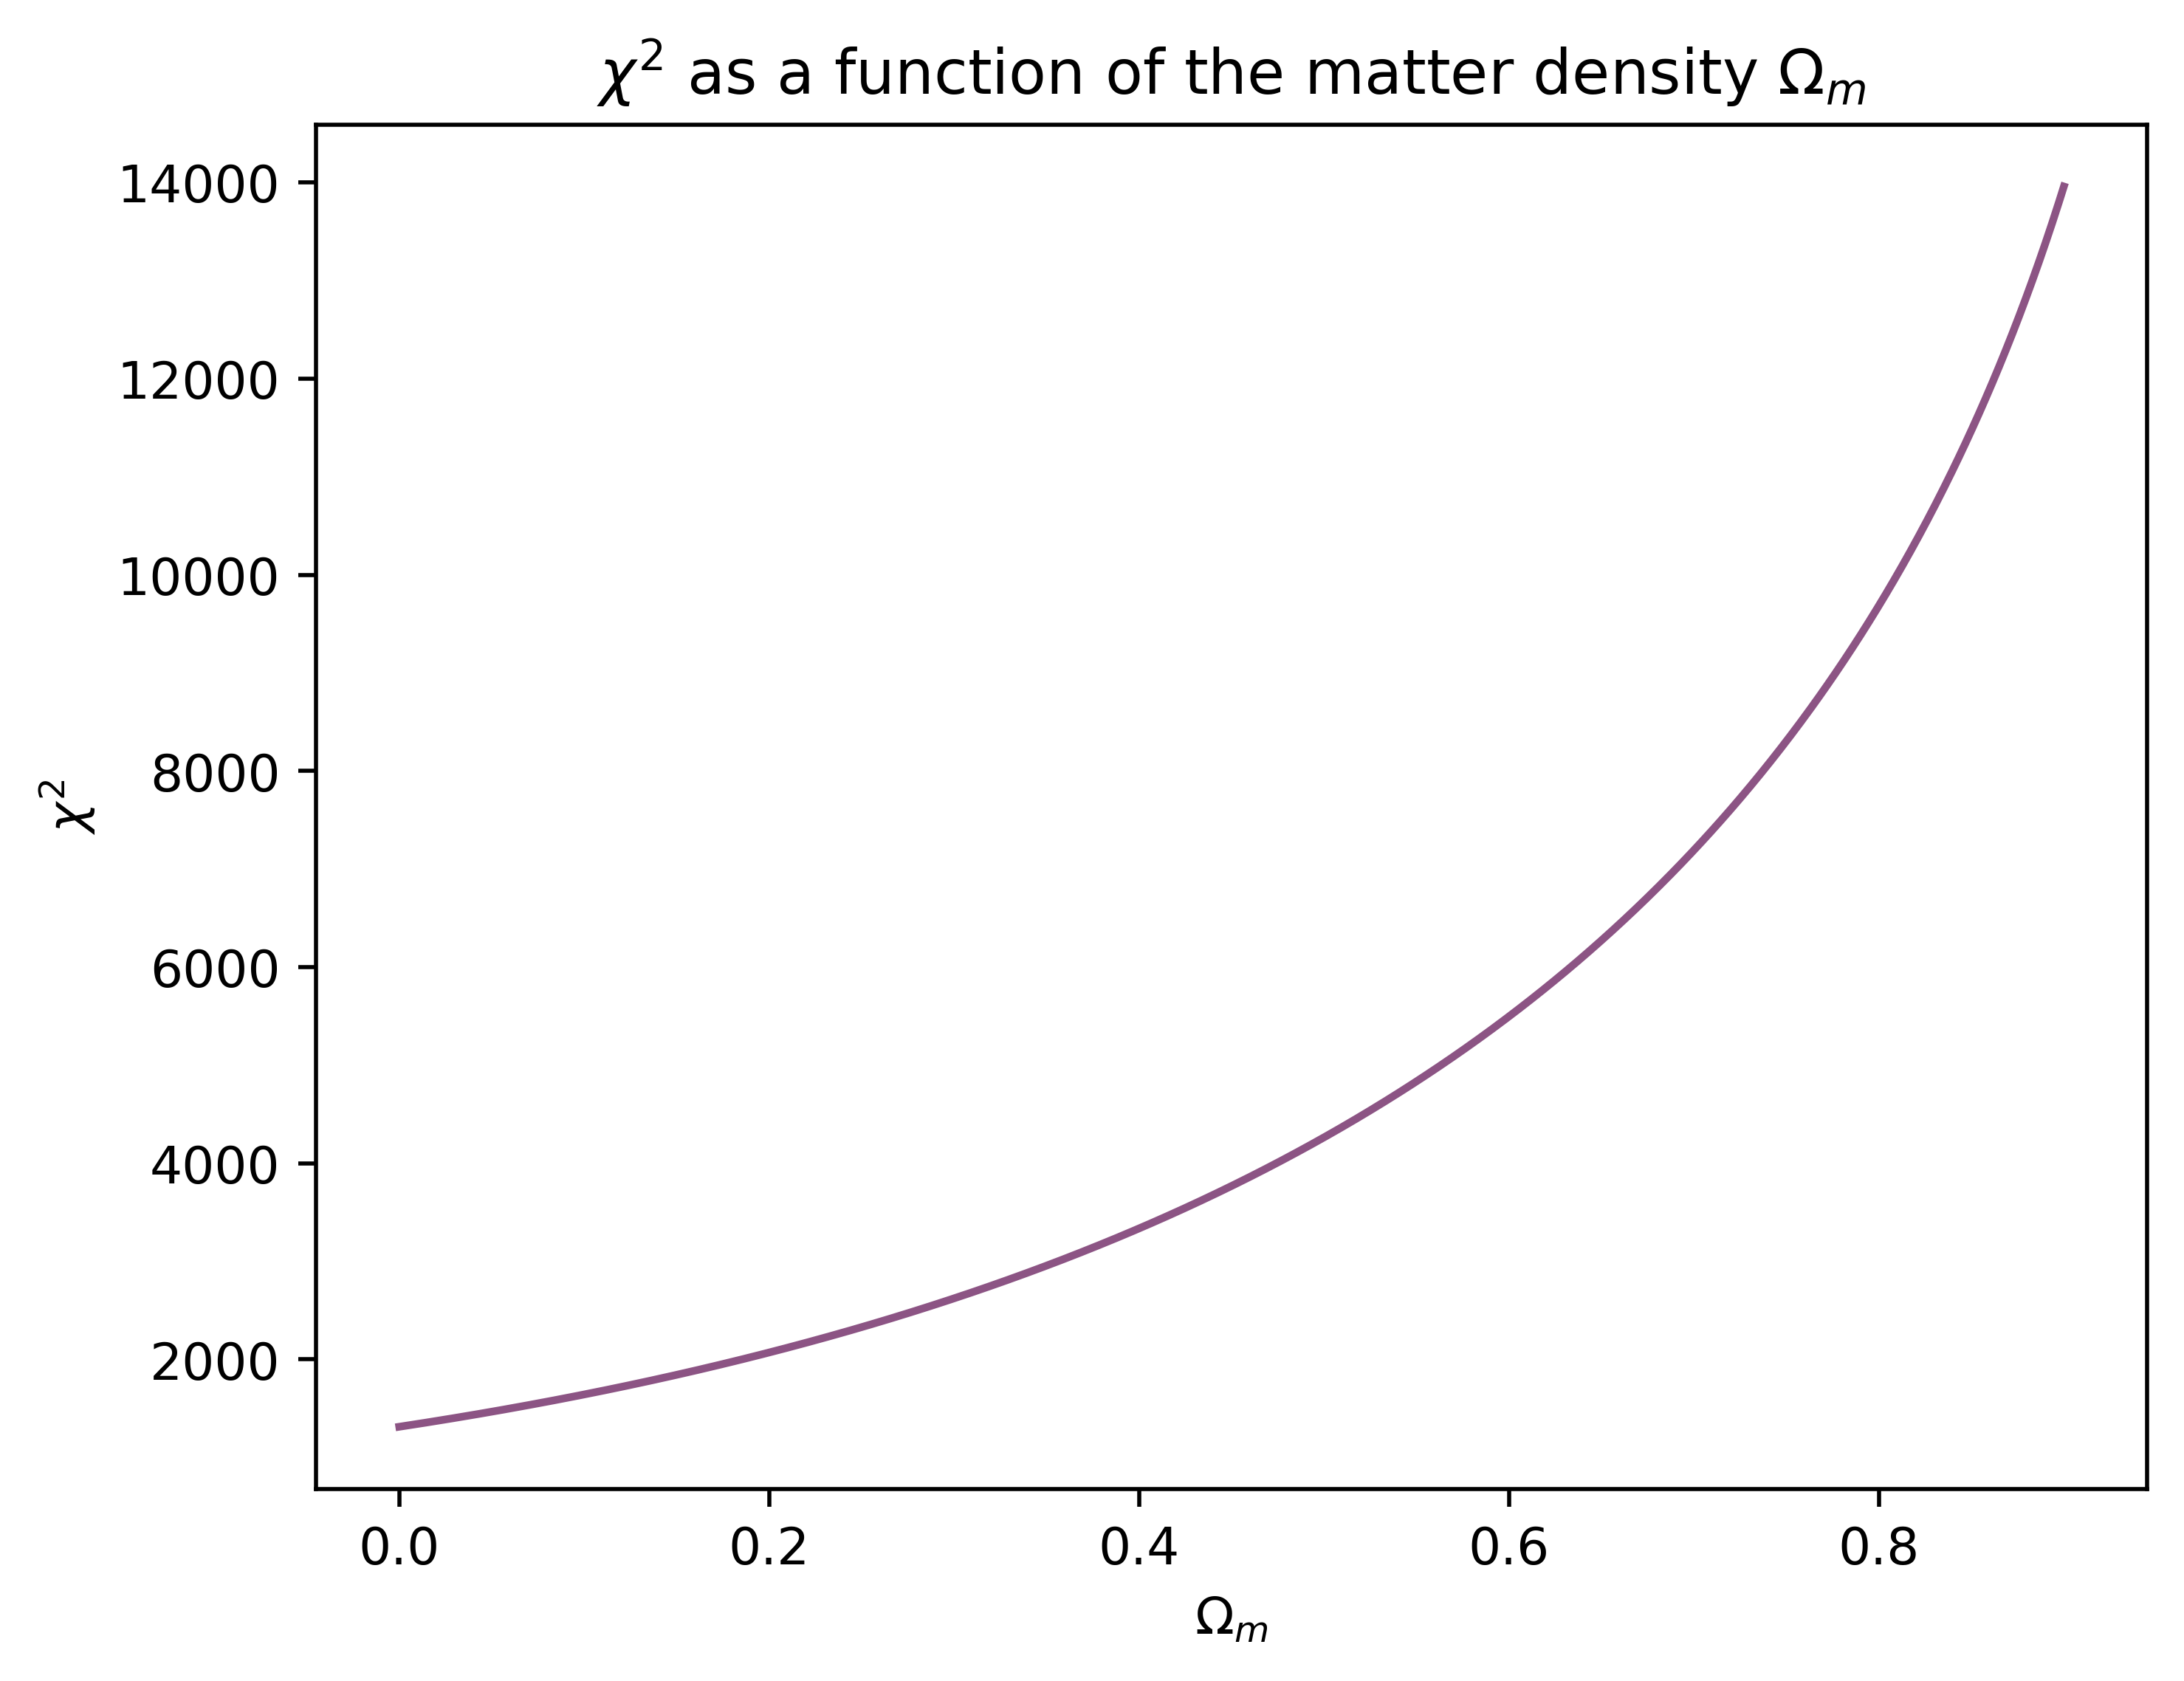

In [37]:
fig, ax = plt.subplots(dpi = 500)

plt.plot(g_omega_m, chi_square, color='#8c5484')
plt.xlabel('$\\Omega_m$')
plt.ylabel('$\\chi^2$')
plt.title('$\\chi^2$ as a function of the matter density $\\Omega_m$')

### e. Fit a Gaussian curve to the likelihood obtained in item [d], and compute the mean and standard variation from this fit. Does the mean coincide with the best-fitted value obtained in it? Also explain.

## 4. Consider the data provided in the data_hmwrk01_ex4.dat file. Let us assume that these value represent the number counts of Active Galaxy Nuclei (AGNs) across 20 disjoint sky regions of the same angular size. Perform a resampling procedure using the bootstrap method with N = 100, N = 1000 and N = 10000. What is the mean and standard deviation obtained from them? Plot the results and explain.